In [24]:

#GENERAL LIBRARIES
import pandas as pd
import numpy as np
import time
import datetime
from dotenv import load_dotenv
import os

#ML LIBRARIES
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style


#DATA REQUESTING LIBRARIES
import quandl
from yahoofinancials import YahooFinancials
import intrinio_sdk

#NN LIBRARIES
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LSTM

#TWITTER SENTIMENT ANALYSIS LIBRARIES
import tweepy as tw
from textblob import TextBlob

In [124]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key


# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date=str(datetime.datetime.now().date())):
    return quandl.get(code, start_date=start_date, end_date=end_date)


# GETS DATA FROM YAHOOFINANCIALS
def yahoo_get(ticker='AAPL', start='1970-01-01', end=str(datetime.datetime.now().date())):
    yahoo_financials = YahooFinancials(ticker)
    dic = yahoo_financials.get_historical_price_data(start, end, 'daily')
    df = pd.DataFrame(dic[ticker]['prices'])
    df['Date'] = pd.to_datetime(df['date'], unit='s').dt.date
    df.drop(columns=['formatted_date', 'date'], inplace=True)
    return df


# CONNECTS TO TWITTER API
def twitter():
    consumer_key = get_key('twitter_api')
    consumer_secret = get_key('twitter_api_secret')
    access_token = get_key('twitter_access_token')
    access_token_secret = get_key('twitter_access_token_secret')
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)
    return api

    
# RETRIEVES ALL TWEETS WITH HASHTAG   
def get_tweets_hash(hashtag, api):
    tmp = []
    for tweet in tw.Cursor(api.search,q=hashtag ,count=100, lang="en",
                           since=str(datetime.datetime.now().date()-datetime.timedelta(days=15)),
                           tweet_mode='extended').items():
        tmp.append((tweet.created_at, tweet.full_text))
        
    df = pd.DataFrame(tmp)
    df['date'] = df[0].dt.date
    group = df.groupby(['date']).sum()
    group['Sentiment'] = group[1].apply(sentiment)
    return group


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_quandl(df, n=10):
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df = df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    df['50ma'] = df['Adj_Close'].rolling(window=50, min_periods=0).mean()
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_yahoo(df, n=5):
    df.index = df['Date']
    df['Volatility'] = (df['high'] - df['low']) / df['low']
    df['Change'] = (df['close'] - df['open']) / df['open']
    df = df[['close', 'Volatility', 'Change', 'volume']]
    df.columns = ['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']
    df['50ma'] = df['Adj_Close'].rolling(window=50, min_periods=0).mean()
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df    
 
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10, title = 'Correlation'):
    style.use('ggplot')
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title(title)
    fig.savefig('images/corr_heatmap.png')

    
#TRAIN LINEAR REGRESSION 
def LSTM_train(data):
    df = data.dropna()
    X = df.drop('future_price10d', axis=1)
    y = df['future_price10d']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=4, batch_size=1, verbose=2)
    score, acc = model.evaluate(X_test, y_test,batch_size=batch_size)
    print('''----- * SCORE & ACCURACY * -----\n\nScore: {}%  Accuracy: {}%
          \n\n----- * SCORE & ACCURACY * -----'''.format(round(score*100,2), round(acc*100,2)))
    return model, score, acc



#TRAIN LINEAR REGRESSION 
def LR_train(data,d):
    df = data.dropna()
    X = df.drop('future_price{}d'.format(d), axis=1)
    y = df['future_price{}d'.format(d)]
    X_train, X_test = X[:int(-0.1*len(X))], X[int(-0.1*(len(X))):]
    y_train, y_test = y[:int(-0.1*len(X))], y[int(-0.1*(len(X))):]
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    print('----- * SCORE * -----\n\n{}%\n\n----- * SCORE * -----'.format(round(score*100,2)))
    return score, reg



#PREDICT FUTURE VALUES
def LR_predict(df, reg, d):
    X = df.drop('future_price{}d'.format(d), axis=1)
    X_predict = X[-d:]
    predictions = reg.predict(X_predict)
    prediction_column = [np.nan for _ in range(len(df)-d)]
    prediction_column.extend(predictions)
    df['Predictions'] = prediction_column
    return predictions, df



#PLOT STOCK PRICE VS TIME
def plot_stock(df, col, size=15, title='Stock'):
    fig = plt.figure(figsize=(size,size))
    style.use('ggplot')
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    fig.suptitle(title)
    ax1.plot(df.index, df[col])
    ax1.plot(df.index, df['50ma'])
    plt.xticks(rotation=90)
    ax2.bar(df.index, df['Adj_Volume'])
    fig.autofmt_xdate()
    plt.show()
    fig.savefig('images/{}.png'.format(title))

    
    
#PLOT PREDICTIONS
def plot_predictions(df, col, size=10, title='Stock-Predictions'):
    fig = plt.figure(figsize=(size,size))
    style.use('ggplot')
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    fig.suptitle(title)
    ax1.plot(df.index, df[col])
    ax1.plot(df.index, df['50ma'])
    plt.xticks(rotation=90)
    ax2.bar(df.index, df['Adj_Volume'])
    fig.autofmt_xdate()
    plt.show()
    fig.savefig('images/{}.png'.format(title))

    
    
#SENTIMENT ANALYSIS
def sentiment(str(text)):
    tweets = TextBlob(text)
    return tweets.sentiment.polarity
#!!!! train lstm model !!!!

SyntaxError: invalid syntax (<ipython-input-124-c78d6a32ef81>, line 170)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


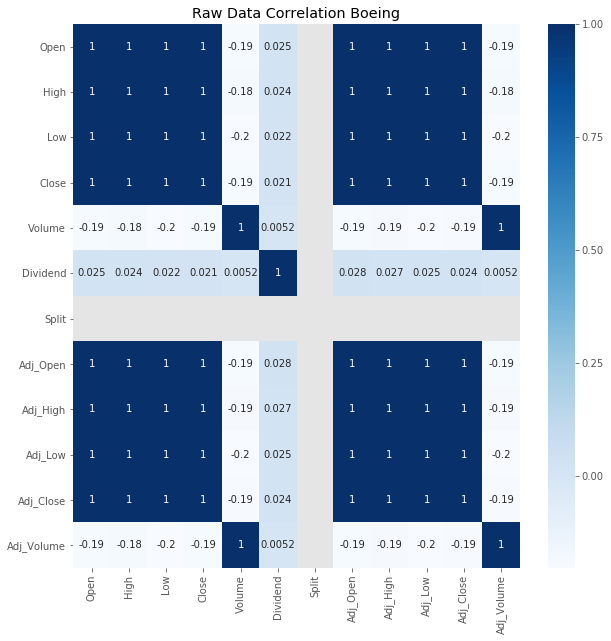

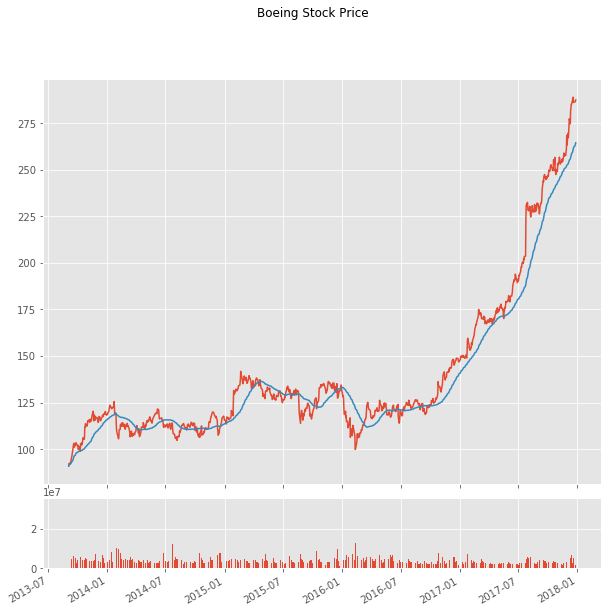

----- * SCORE * -----

85.29%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/p

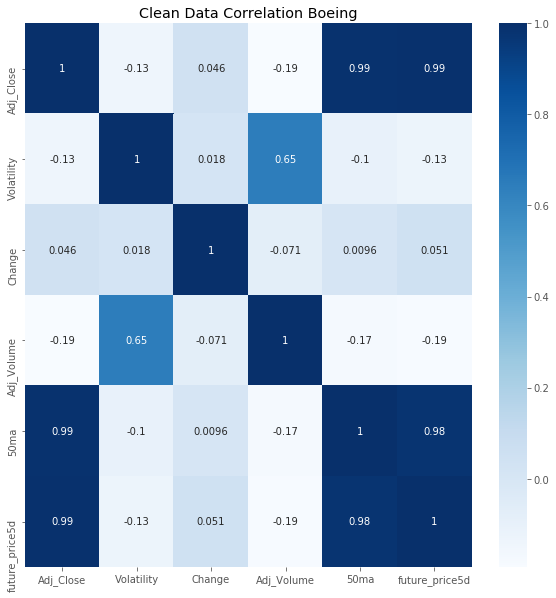

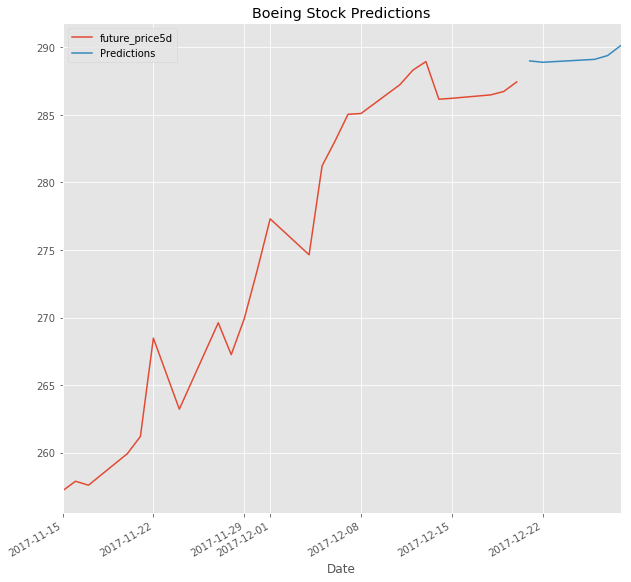

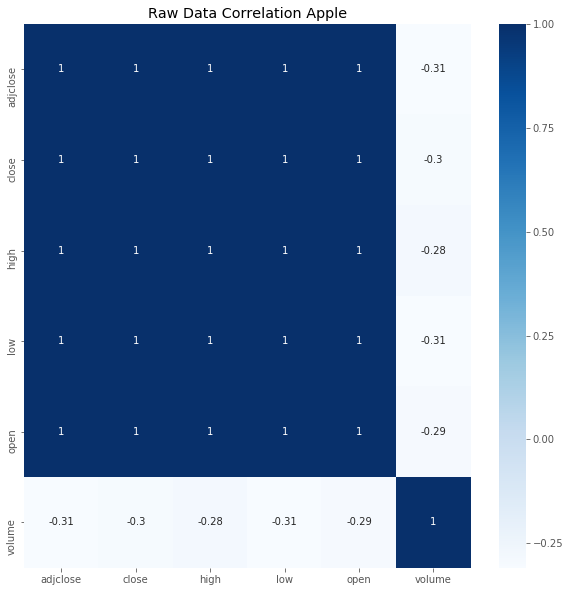

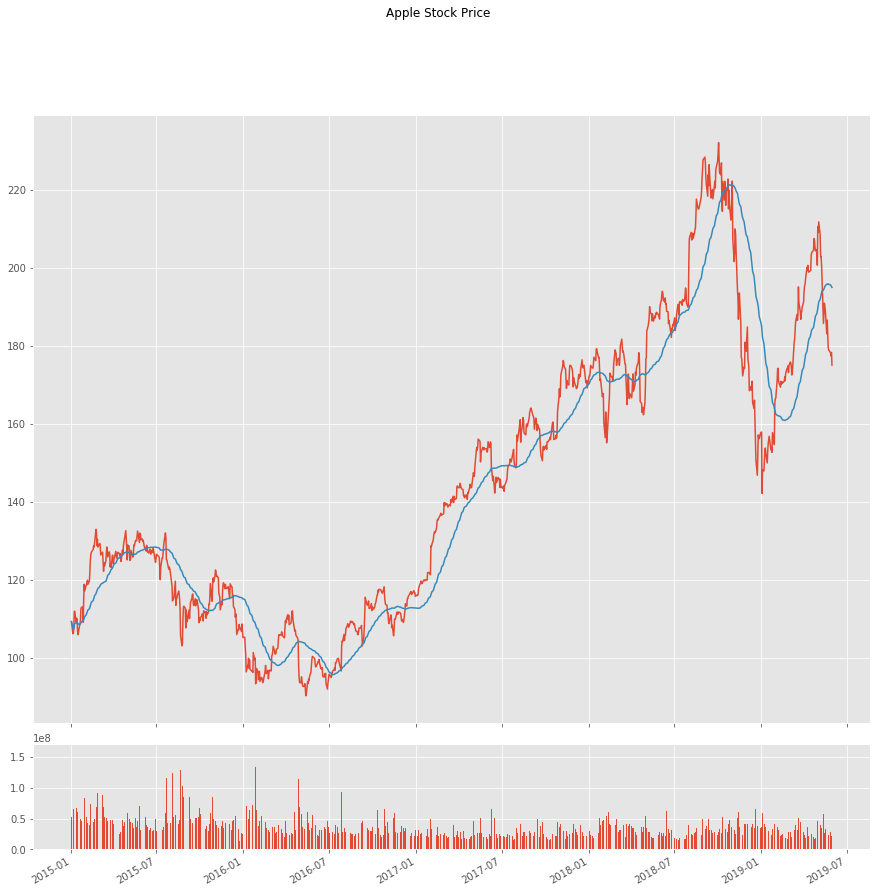

----- * SCORE * -----

84.16%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TypeError: get_tweets_hash() missing 1 required positional argument: 'api'

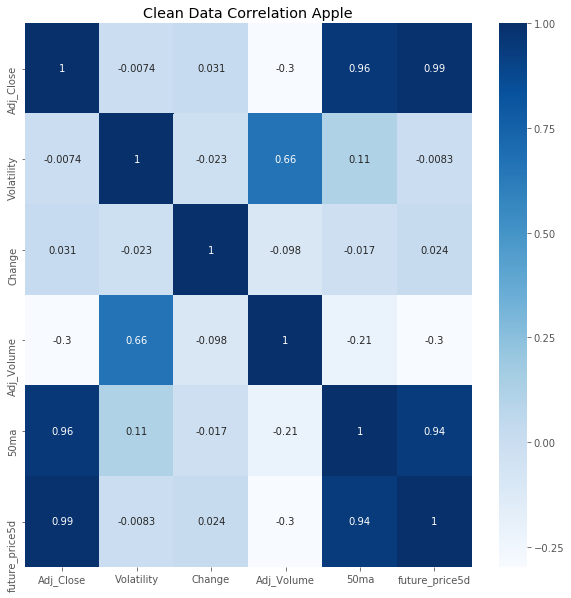

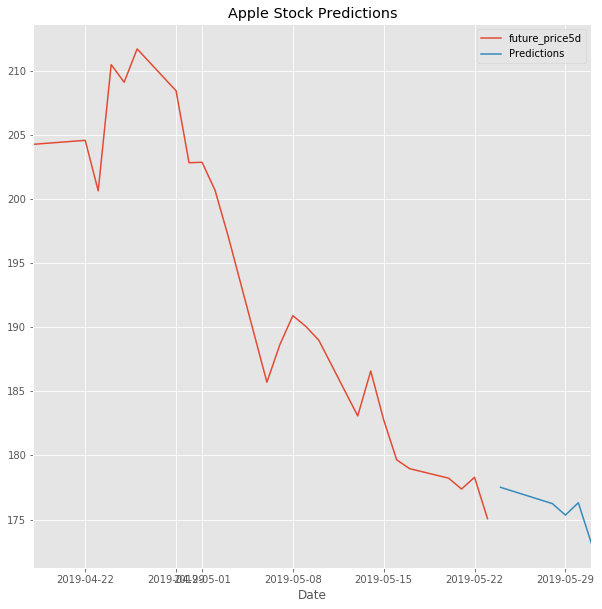

In [123]:
if __name__ == "__main__":
    
    #Define the forecast that the model is train to predict
    days_predict = 5
    
    #Request Quandl for the BOEING COMPANY historic data
    quandl_key = get_key('quandl_key')
    quandl.ApiConfig.api_key = quandl_key
    boeing = quandl_get('EOD/BA')
    
    #Plot data and feature correlation, clean data and featurure engineering
    plot_corr(boeing, 10, 'Raw Data Correlation Boeing')
    boeing_clean = feature_eng_quandl(boeing, days_predict)
    plot_stock(boeing_clean, 'Adj_Close',10,'Boeing Stock Price')
    plot_corr(boeing_clean, 10,'Clean Data Correlation Boeing')
    
    #Train model and predict Close Stock Prices BA
    score_boeing, reg_boeing = LR_train(boeing_clean, days_predict)
    predictions_boeing, boeing_predicted = LR_predict(boeing_clean, reg_boeing, days_predict)
    plot_predictions(boeing_predicted,['future_price{}d'.format(days_predict), 'Predictions'] , 10, 'Boeing Stock Predictions')
    
    #Request YahooFinance library for Apples's historic data
    apple = yahoo_get('AAPL', '2015-01-01', str(datetime.datetime.now().date()))
    plot_corr(apple, 10, 'Raw Data Correlation Apple')
    apple_clean = feature_eng_yahoo(apple, days_predict)
    plot_stock(apple_clean, 'Adj_Close', 15 ,'Apple Stock Price')
    plot_corr(apple_clean, 10,'Clean Data Correlation Apple')
    
    #Train model and predict Close Stock Prices AAPL
    score_apple, reg_apple = LR_train(apple_clean, days_predict)
    predictions_apple, apple_predicted = LR_predict(apple_clean, reg_apple, days_predict)
    plot_predictions(apple_predicted,['future_price{}d'.format(days_predict), 'Predictions'] , 10, 'Apple Stock Predictions')
    
    #Retrieve related tweets
    api = twitter()
    appl_tw = get_tweets_hash('#AAPL', api)

In [108]:
api = twitter()
appl_tw = get_tweets_hash('#AAPL', api)

In [115]:
df = appl_tw.copy()
df

,1
date,
2019-05-24,Apple Confirms ECG Functionality is Coming to ...
2019-05-25,💻 #Bitcoin $8085 vs 🦍 #AAPL $180.2\n\n ...
2019-05-26,RT @PokerTraderRay: **FREE Post BTFD (Buy the ...
2019-05-27,@Apple The R is for the #Resistance because @t...
2019-05-28,Designer Creates Classic Mac You Can Hug With ...
2019-05-29,"Apple launches new iPod touch with A10 chip, 2..."
2019-05-30,"Smart Battery Cases for iPhone XS, XS Max, and..."
2019-05-31,RT @StockRockNRoll: $GTEH should be the only t...
2019-06-01,$ES_F - Daily / Weekly Charts\n\nBy looking at...


In [119]:
df['Sentiment'] = df[1].apply(sentiment)

In [120]:
df

,1,Sentiment
date,,
2019-05-24,Apple Confirms ECG Functionality is Coming to ...,"(-0.023809523809523808, 0.3514652014652015)"
2019-05-25,💻 #Bitcoin $8085 vs 🦍 #AAPL $180.2\n\n ...,"(0.30247921390778537, 0.5702418745275889)"
2019-05-26,RT @PokerTraderRay: **FREE Post BTFD (Buy the ...,"(0.11767676767676769, 0.42474747474747476)"
2019-05-27,@Apple The R is for the #Resistance because @t...,"(0.08611111111111112, 0.31979166666666664)"
2019-05-28,Designer Creates Classic Mac You Can Hug With ...,"(0.13578756313131313, 0.35606849747474756)"
2019-05-29,"Apple launches new iPod touch with A10 chip, 2...","(0.05552917232021707, 0.3853663500678426)"
2019-05-30,"Smart Battery Cases for iPhone XS, XS Max, and...","(0.08773372018052868, 0.41725154278345755)"
2019-05-31,RT @StockRockNRoll: $GTEH should be the only t...,"(0.06897065897065896, 0.49792989417989414)"
2019-06-01,$ES_F - Daily / Weekly Charts\n\nBy looking at...,"(0.08571428571428573, 0.6928571428571427)"
